In [1]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
path = '../Neuro_dataset/'
path_alz = path + os.listdir(path)[1]
path_nor = path + os.listdir(path)[2]

In [4]:
files_alz = os.listdir(path_alz)
files_nor = os.listdir(path_nor)
d = loadmat(path_alz + '/' + files_alz[0])
d['tc_rest_aal'] = d['tc_rest_aal'].reshape((1, 140, 116))
d['tc_rest_power'] = d['tc_rest_power'].reshape((1, 140, 264))
X_aal = d['tc_rest_aal']
X_pow = d['tc_rest_power']

for i in range(1, len(files_alz)):
    d = loadmat(path_alz + '/' + files_alz[i])
    d['tc_rest_aal'] = d['tc_rest_aal'].reshape((1, 140, 116))
    d['tc_rest_power'] = d['tc_rest_power'].reshape((1, 140, 264))
    X_aal = np.vstack([X_aal, d['tc_rest_aal']])
    X_pow = np.vstack([X_pow, d['tc_rest_power']])

for i in range(len(files_nor)):
    d = loadmat(path_nor + '/' + files_nor[i])
    d['tc_rest_aal'] = d['tc_rest_aal'].reshape((1, 140, 116))
    d['tc_rest_power'] = d['tc_rest_power'].reshape((1, 140, 264))
    X_aal = np.vstack([X_aal, d['tc_rest_aal']])
    X_pow = np.vstack([X_pow, d['tc_rest_power']])

In [5]:
X_aal.shape

(81, 140, 116)

In [6]:
X_pow.shape

(81, 140, 264)

In [7]:
y = [1 for i in range(34)]
y.extend([0 for i in range(47)])
y = np.array(y).reshape((81, 1))
y.shape

(81, 1)

In [27]:
X = np.dstack([X_aal, X_pow])

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
a = X_train.shape[1]
b = X_train.shape[2]
print(X_train.shape, X_test.shape)

(64, 140, 380) (17, 140, 380)


In [58]:
X_train = (X_train - X_train.mean(axis=0))/X_train.std(axis=0)
X_test = (X_test - X_train.mean(axis=0))/X_train.std(axis=0)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
print(X_train.shape, X_test.shape)

(64, 140, 380, 1) (17, 140, 380, 1)


In [59]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.0)

In [60]:
datagen.fit(X_train)

In [66]:
lam = tf.keras.regularizers.l1(l=0)
# lam_2 = tf.keras.regularizers.l2(l=0.01)
init = tf.initializers.he_normal()
model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(8, (3, 3), padding='same', kernel_initializer=init, input_shape=(a, b, 1), kernel_regularizer=lam),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2D(16, (3, 3), padding='same', kernel_initializer=init, kernel_regularizer=lam),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.MaxPool2D((2, 4)),

    tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer=init, kernel_regularizer=lam),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=init, kernel_regularizer=lam),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), padding='valid', kernel_initializer=init, kernel_regularizer=lam),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Conv2D(160, (3, 3), padding='same', kernel_initializer=init, kernel_regularizer=lam),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dropout(0.2),

    # tf.keras.layers.Dense(128, kernel_initializer=init, kernel_regularizer=lam),
    # tf.keras.layers.ReLU(),
    # tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(16, kernel_initializer=init, kernel_regularizer=lam),
    tf.keras.layers.ReLU(),
    # tf.keras.layers.LeakyReLU(0.1),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=init, kernel_regularizer=lam)
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 140, 380, 8)       80        
_________________________________________________________________
re_lu_33 (ReLU)              (None, 140, 380, 8)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 140, 380, 16)      1168      
_________________________________________________________________
re_lu_34 (ReLU)              (None, 140, 380, 16)      0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 70, 95, 16)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 70, 95, 32)        4640      
_________________________________________________________________
re_lu_35 (ReLU)              (None, 70, 95, 32)       

In [67]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [68]:
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

In [69]:
# history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test))

In [70]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=4), epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
16/16 [==============================] - 2s 46ms/step - loss: 2.4406 - accuracy: 0.4808 - val_loss: 17.1693 - val_accuracy: 0.4118
Epoch 2/100
16/16 [==============================] - 1s 38ms/step - loss: 0.6847 - accuracy: 0.5034 - val_loss: 0.6922 - val_accuracy: 0.5882
Epoch 3/100
16/16 [==============================] - 0s 20ms/step - loss: 0.6930 - accuracy: 0.5116 - val_loss: 0.6919 - val_accuracy: 0.5882
Epoch 4/100
16/16 [==============================] - 0s 19ms/step - loss: 0.6917 - accuracy: 0.5980 - val_loss: 0.6914 - val_accuracy: 0.5882
Epoch 5/100
16/16 [==============================] - 0s 20ms/step - loss: 0.6908 - accuracy: 0.6168 - val_loss: 0.6910 - val_accuracy: 0.5882
Epoch 6/100
16/16 [==============================] - 0s 20ms/step - loss: 0.6921 - accuracy: 0.5446 - val_loss: 0.6908 - val_accuracy: 0.5882
Epoch 7/100
16/16 [==============================] - 0s 20ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6905 - val_accuracy: 0.5882
Epoch

In [71]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5

In [72]:
from sklearn.metrics import accuracy_score, confusion_matrix
a = accuracy_score(y_pred,y_test)
print('Accuracy is:', a*100)

Accuracy is: 58.82352941176471


Text(0.5, 1.0, "'aal'+'power' dataset")

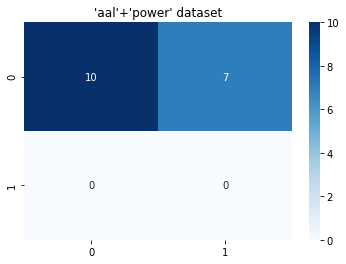

In [76]:
sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt='g', cmap='Blues')
plt.title("'aal'+'power' dataset")

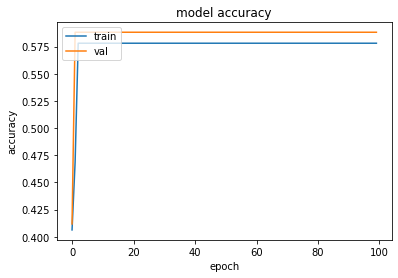

In [74]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.xticks([i for i in range(25)])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

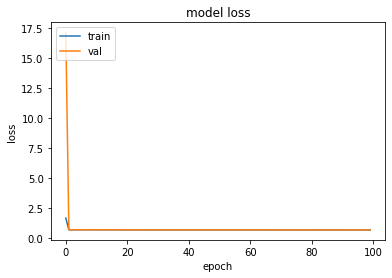

In [75]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.xticks([i for i in range(25)])
plt.legend(['train', 'val'], loc='upper left')
plt.show()